# MobileNetV2 – RSNA Pneumonia Detection


In [1]:
import os, cv2, pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

In [2]:
TRAIN_IMG_DIR = "/kaggle/input/competitions/rsna-pneumonia-detection-challenge/stage_2_train_images"
CSV_PATH      = "/kaggle/input/competitions/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"

train_df = pd.read_csv(CSV_PATH)
df = (
    train_df
    .groupby("patientId")["Target"]
    .max()
    .reset_index()
    .rename(columns={"Target": "label"})
)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=42)
val_df,   test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42)
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

Train: 18678 Val: 4003 Test: 4003


In [3]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class RSNADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pid   = self.df.loc[idx, "patientId"]
        label = self.df.loc[idx, "label"]
        dcm   = pydicom.dcmread(os.path.join(self.img_dir, pid + ".dcm"))
        img   = cv2.normalize(dcm.pixel_array, None, 0, 255, cv2.NORM_MINMAX)
        img   = np.stack([img] * 3, axis=-1).astype(np.uint8)
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)

In [4]:
BATCH_SIZE = 32
train_loader = DataLoader(RSNADataset(train_df, TRAIN_IMG_DIR, transform), batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(RSNADataset(val_df,   TRAIN_IMG_DIR, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(RSNADataset(test_df,  TRAIN_IMG_DIR, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [5]:
# ── MobileNetV2 ───────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
# Replace the final classifier: MobileNetV2 classifier is model.classifier[1]
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 126MB/s]


In [6]:
EPOCHS    = 40
PATIENCE  = 5
THRESHOLD = 0.5
MODEL_SAVE = "best_mobilenetv2.pth"

history = {k: [] for k in
    ["train_loss","val_loss","train_acc","val_acc",
     "train_prec","val_prec","train_f1","val_f1",
     "train_auc","val_auc"]}

best_loss, patience_ctr = float("inf"), 0

def compute_metrics(y_true, y_prob):
    y_pred = (y_prob > THRESHOLD).astype(int)
    return accuracy_score(y_true, y_pred), \
           precision_score(y_true, y_pred, zero_division=0), \
           f1_score(y_true, y_pred, zero_division=0), \
           roc_auc_score(y_true, y_prob)

for epoch in range(EPOCHS):
    model.train()
    t_loss, t_probs, t_labels = [], [], []
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x, y = x.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        logits = model(x)
        loss   = criterion(logits, y)
        loss.backward(); optimizer.step()
        t_loss.append(loss.item())
        t_probs.append(torch.sigmoid(logits).detach().cpu())
        t_labels.append(y.cpu())
    t_probs  = torch.cat(t_probs).numpy()
    t_labels = torch.cat(t_labels).numpy()

    model.eval()
    v_loss, v_probs, v_labels = [], [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            x, y = x.to(device), y.to(device).unsqueeze(1)
            logits = model(x)
            v_loss.append(criterion(logits, y).item())
            v_probs.append(torch.sigmoid(logits).cpu())
            v_labels.append(y.cpu())
    v_probs  = torch.cat(v_probs).numpy()
    v_labels = torch.cat(v_labels).numpy()

    t_acc,t_prec,t_f1,t_auc = compute_metrics(t_labels,t_probs)
    v_acc,v_prec,v_f1,v_auc = compute_metrics(v_labels,v_probs)

    for key,val in zip(history.keys(),
        [np.mean(t_loss),np.mean(v_loss),t_acc,v_acc,
         t_prec,v_prec,t_f1,v_f1,t_auc,v_auc]):
        history[key].append(val)

    print(f"Epoch {epoch+1} | Train Loss {np.mean(t_loss):.5f} | Val Loss {np.mean(v_loss):.5f} | Val AUC {v_auc:.5f}")

    if np.mean(v_loss) < best_loss:
        best_loss=np.mean(v_loss); patience_ctr=0
        torch.save(model.state_dict(), MODEL_SAVE)
    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print("Early stopping"); break

Epoch 1 [Val]: 100%|██████████| 126/126 [00:46<00:00,  2.72it/s]


Epoch 1 | Train Loss 0.38053 | Val Loss 0.35428 | Val AUC 0.87693


Epoch 2 [Val]: 100%|██████████| 126/126 [00:33<00:00,  3.72it/s]


Epoch 2 | Train Loss 0.33563 | Val Loss 0.35757 | Val AUC 0.87119


Epoch 3 [Val]: 100%|██████████| 126/126 [00:35<00:00,  3.54it/s]


Epoch 3 | Train Loss 0.29574 | Val Loss 0.38176 | Val AUC 0.86882


Epoch 4 [Val]: 100%|██████████| 126/126 [00:33<00:00,  3.74it/s]


Epoch 4 | Train Loss 0.23780 | Val Loss 0.42365 | Val AUC 0.84883


Epoch 5 [Val]: 100%|██████████| 126/126 [00:34<00:00,  3.67it/s]


Epoch 5 | Train Loss 0.16559 | Val Loss 0.54655 | Val AUC 0.85157


Epoch 6 [Val]: 100%|██████████| 126/126 [00:35<00:00,  3.53it/s]

Epoch 6 | Train Loss 0.10557 | Val Loss 0.70673 | Val AUC 0.85380
Early stopping


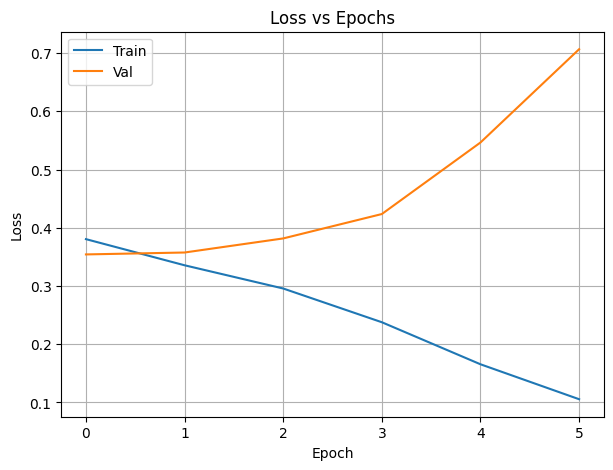

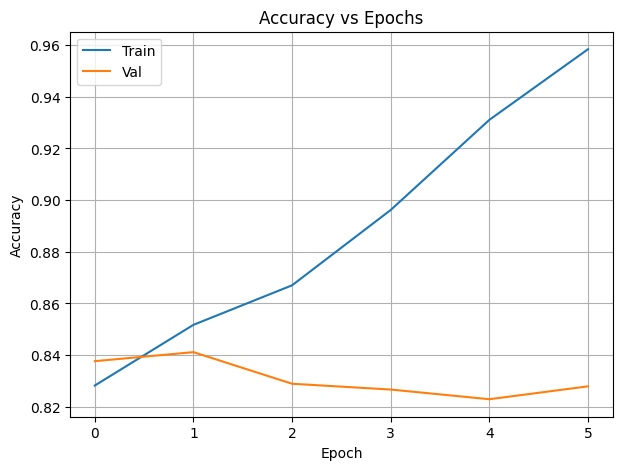

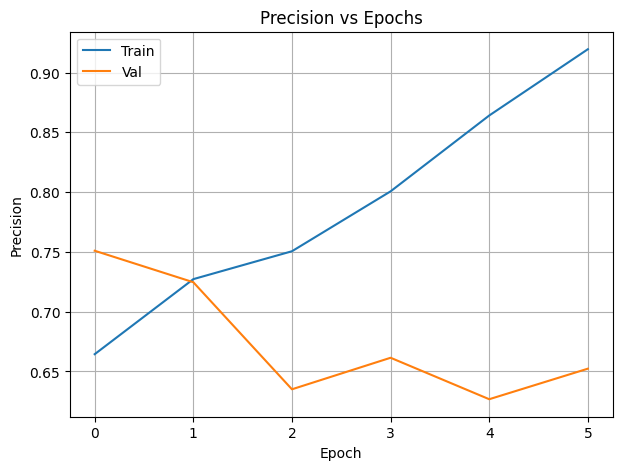

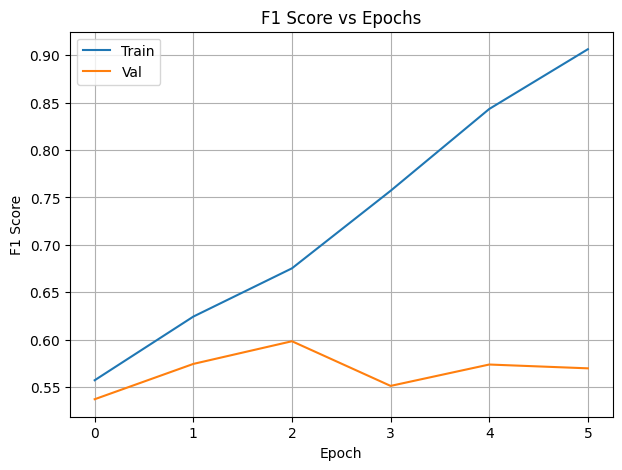

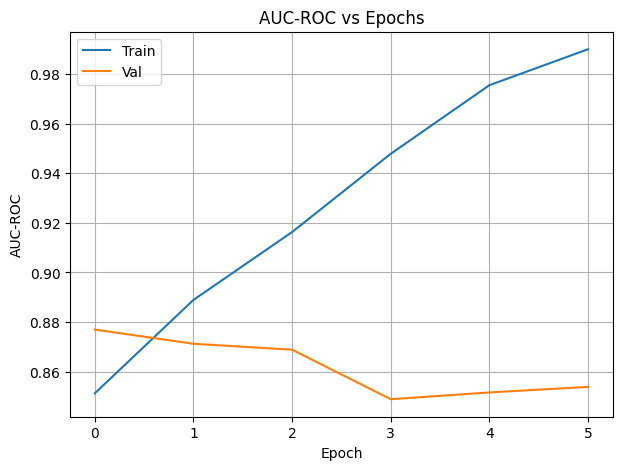

In [7]:
def plot_metric(name, ylabel):
    plt.figure(figsize=(7,5))
    plt.plot(history[f"train_{name}"], label="Train")
    plt.plot(history[f"val_{name}"],   label="Val")
    plt.xlabel("Epoch"); plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs Epochs"); plt.legend(); plt.grid(); plt.show()

for m,l in [("loss","Loss"),("acc","Accuracy"),("prec","Precision"),("f1","F1 Score"),("auc","AUC-ROC")]:
    plot_metric(m,l)

              precision    recall  f1-score   support

         0.0    0.85093   0.95905   0.90176      3101
         1.0    0.75000   0.42239   0.54043       902

    accuracy                        0.83812      4003
   macro avg    0.80046   0.69072   0.72109      4003
weighted avg    0.82819   0.83812   0.82034      4003



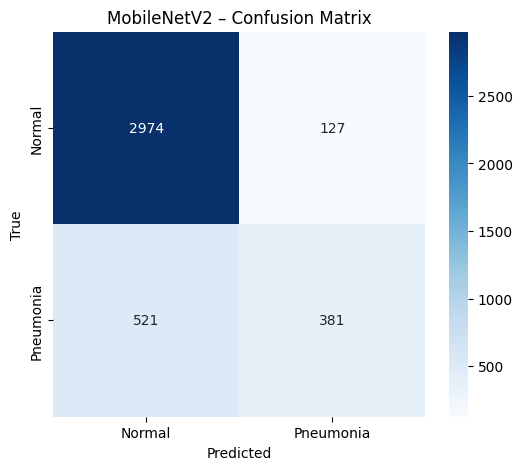

In [8]:
model.load_state_dict(torch.load(MODEL_SAVE))
model.eval()
probs, labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        probs.append(torch.sigmoid(model(x.to(device))).cpu())
        labels.append(y.unsqueeze(1))
probs  = torch.cat(probs).numpy()
labels = torch.cat(labels).numpy()
preds  = (probs > THRESHOLD).astype(int)
print(classification_report(labels, preds, digits=5))
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Pneumonia"],
            yticklabels=["Normal","Pneumonia"])
plt.title("MobileNetV2 – Confusion Matrix")
plt.ylabel("True"); plt.xlabel("Predicted"); plt.show()